# This is a stock price predictor for any stock.
## By Niam Bashambu

In [1]:
#doing imports
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Bidirectional
from pandas_datareader import data
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import time


You can change the ticker here below, to update the stock you want to see

In [2]:

tickers = 'NVDA'

start_date = '2020-01-01'
end_date = '2025-01-01'

stock_data = yf.download(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
#Print data
stock_data.head(10)

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.972711,5.972711,5.893294,5.943832,237536000
2020-01-03,5.877111,5.920927,5.828066,5.852962,205384000
2020-01-06,5.901758,5.906986,5.757612,5.783753,262636000
2020-01-07,5.973207,6.019015,5.885077,5.930138,314856000
2020-01-08,5.984411,6.025738,5.928894,5.968976,277108000
2020-01-09,6.050138,6.122584,5.996363,6.070801,255112000
2020-01-10,6.082500,6.187809,6.068310,6.157436,316296000
2020-01-13,6.273202,6.298347,6.142998,6.165653,319840000


In [4]:
stock_data.reset_index(inplace=True)
stock_data.dropna(inplace=True)
stock_data

Price,Date,Close,High,Low,Open,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
0,2020-01-02,5.972711,5.972711,5.893294,5.943832,237536000
1,2020-01-03,5.877111,5.920927,5.828066,5.852962,205384000
2,2020-01-06,5.901758,5.906986,5.757612,5.783753,262636000
3,2020-01-07,5.973207,6.019015,5.885077,5.930138,314856000
4,2020-01-08,5.984411,6.025738,5.928894,5.968976,277108000
...,...,...,...,...,...,...
1253,2024-12-24,140.220001,141.899994,138.649994,140.000000,105157000
1254,2024-12-26,139.929993,140.850006,137.729996,139.699997,116205600
1255,2024-12-27,137.009995,139.020004,134.710007,138.550003,170582600


In [5]:
stock_data.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,NVDA,NVDA,NVDA,NVDA,NVDA
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2022-07-01 15:39:46.645468928,38.445948,39.156301,37.671665,38.450352,4.468056e+08
min,2020-01-02 00:00:00,4.892426,5.229716,4.500834,4.984596,9.788400e+07
25%,2021-04-02 00:00:00,13.573232,13.824405,13.338219,13.605262,3.084230e+08
50%,2022-06-30 12:00:00,21.237931,21.744670,20.824598,21.172295,4.209180e+08
75%,2023-10-01 06:00:00,45.626478,46.206085,44.970616,45.750924,5.467242e+08
max,2024-12-31 00:00:00,148.869751,152.879470,146.249911,149.339720,1.543911e+09
std,NaN,38.233881,38.944453,37.489330,38.295294,1.877132e+08


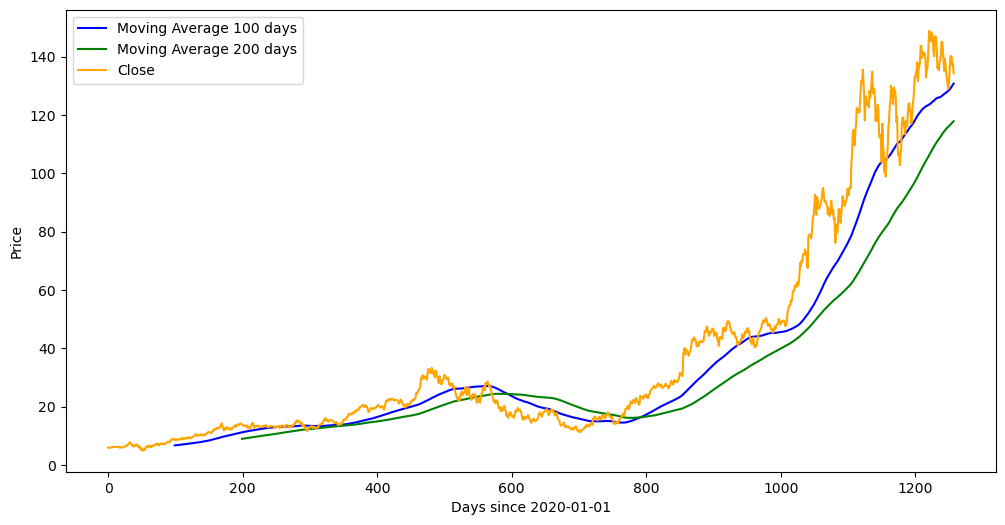

In [6]:
#Plotting the data and the moving averages
avg1 = stock_data['Close'].rolling(100).mean()
avg2 = stock_data['Close'].rolling(200).mean()
plt.figure(figsize=(12,6))
plt.plot(avg1, 'blue', label='Moving Average 100 days')
plt.plot(avg2, 'green', label='Moving Average 200 days')
plt.plot(stock_data['Close'], 'orange', label='Close')
plt.legend(loc='upper left')
plt.xlabel(f'Days since {start_date}')
plt.ylabel('Price')
plt.show()

In [7]:
#Train test split
train, test = train_test_split(stock_data['Close'], test_size=0.2, shuffle=False)



In [8]:
#Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))



In [9]:
#Creating the x_train and y_train
x_train = []
y_train = []

for i in range(100, train_scaled.shape[0]):
    x_train.append(train_scaled[i-100:i])
    y_train.append(train_scaled[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)


#Creating the x_test and y_test
x_test = []
y_test = []

for i in range(100, test_scaled.shape[0]):
    x_test.append(test_scaled[i-100:i])
    y_test.append(test_scaled[i, 0])
    
x_test, y_test = np.array(x_test), np.array(y_test)



In [68]:
#Creating the model
model = Sequential()


# First LSTM layer
model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.1))

# Second LSTM layer
model.add(LSTM(units=100, activation='relu', return_sequences=True))
model.add(Dropout(0.1))

# Third LSTM layer
model.add(LSTM(units=150, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))



/Users/niambashambu/anaconda3/envs/ds/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
model.compile(optimizer='adamax', loss='mean_squared_error')


Fitting the model using 50 epochs, probably not the best for a dataset of this size, could definitely increase for less loss. 

In [ ]:

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.1374 - val_loss: 74036.7266 - learning_rate: 0.0010
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0124 - val_loss: 5515566080.0000 - learning_rate: 0.0010
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0078 - val_loss: 486748576.0000 - learning_rate: 0.0010
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0067 - val_loss: 13285908.0000 - learning_rate: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0053 - val_loss: 977592.5000 - learning_rate: 0.0010
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0040 - val_loss: 21563.0371 - learning_rate: 0.0010
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0045 - val_loss: 1911.8539 - learning_rate: 0.0010
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0048 - val_loss: 108.7197 - learning_rate: 0.0010
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0032 - val_loss: 34.0604 

In [71]:
y_predict = model.predict(x_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [72]:
scale = 1/scaler.scale_
y_predict = y_predict*scale
y = y_test*scale

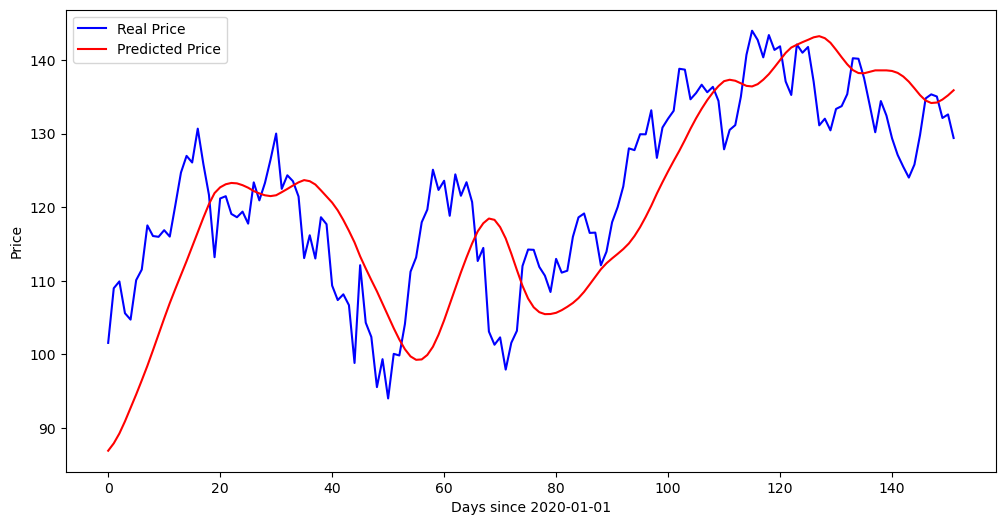

In [73]:
plt.figure(figsize=(12,6))
plt.plot(y, 'b', label='Real Price')
plt.plot(y_predict, 'r', label='Predicted Price')
plt.xlabel(f'Days since {start_date}')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [16]:
model.save('stock_predictor.h5')